In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("data"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from pycaret.time_series import *

color_pal = sns.color_palette()
plt.style.use("fivethirtyeight")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


data\anomalyze_df.csv
data\change-energy-consumption.csv
data\fossil-fuel-consumption-by-type.csv
data\fossil-fuel-primary-energy.csv
data\oil-production-by-country.csv
data\oil-share-energy.csv
data\per-capita-energy-use.csv
data\petr_brent.csv
data\petr_brent_.csv
data\price.csv
data\share-electricity-fossil-fuels.csv


In [2]:
data = pd.read_csv("data/petr_brent.csv")[["DATE", "VALUE (US$)"]]

# data = pd.read_csv("data/anomalyze_df.csv")[["date", "observed_clean"]]
# data.rename(columns={"date": "DATE", "observed_clean": "VALUE (US$)"}, inplace=True)
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7984 entries, 0 to 7983
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE         7984 non-null   object 
 1   VALUE (US$)  7735 non-null   float64
dtypes: float64(1), object(1)
memory usage: 124.9+ KB


In [3]:
data.index = pd.to_datetime(data["DATE"])
start = data.index[0].date()
end = data.index[len(data) - 1].date()
new_dates = pd.date_range(start=start, end=end, freq="D")
data = data.reindex(new_dates)
data = data.rename_axis("DATE")
data["VALUE (US$)"] = data["VALUE (US$)"].interpolate().bfill()
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8562 entries, 2001-01-01 to 2024-06-10
Freq: D
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE         7984 non-null   object 
 1   VALUE (US$)  8562 non-null   float64
dtypes: float64(1), object(1)
memory usage: 200.7+ KB


In [4]:
# data.drop(["DATE", "CODE", "RAW DATE"], axis=1, inplace=True)
data.drop(["DATE"], axis=1, inplace=True)
data.head()


VALUE (US$)
DATE                   
2001-01-01        23.43
2001-01-02        23.43
2001-01-03        23.44
2001-01-04        24.57
2001-01-05        24.77

<Axes: title={'center': 'Preço Petróleo tipo Brent'}, xlabel='DATE'>

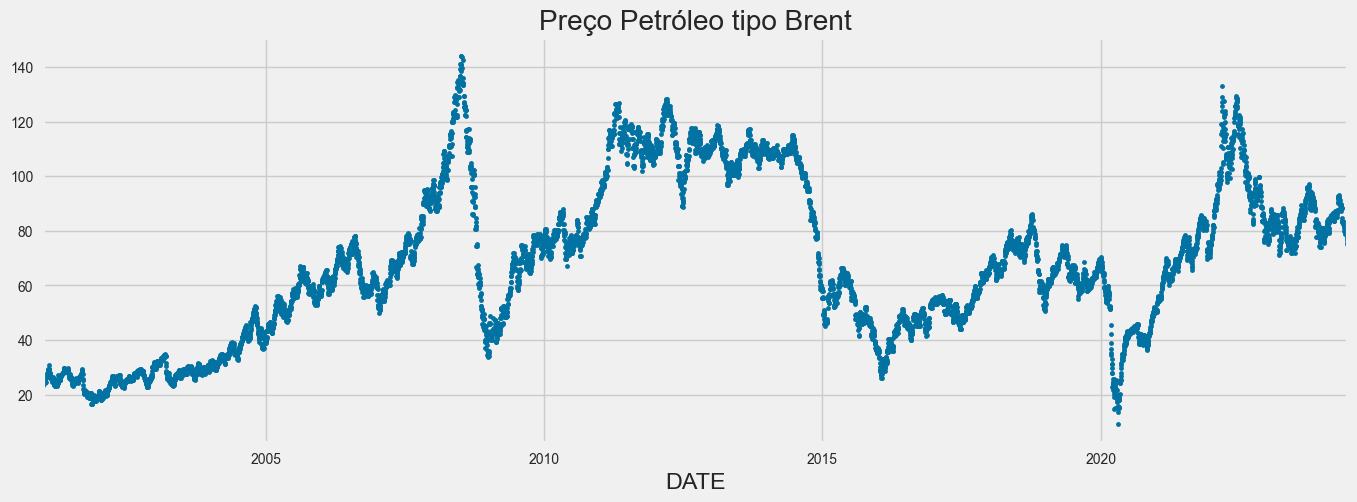

In [5]:
# df.plot(style='.', figsize=(15,5), color=color_pal[0], title = "PJME Energy Use in Mega walt (MW)");
data["VALUE (US$)"].plot(
    style=".", figsize=(15, 5), color=color_pal[0], title="Preço Petróleo tipo Brent"
)


In [6]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.day_of_week
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.day_of_year
    return df


df = create_features(data)


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8562 entries, 2001-01-01 to 2024-06-10
Freq: D
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   VALUE (US$)  8562 non-null   float64
 1   hour         8562 non-null   int32  
 2   dayofweek    8562 non-null   int32  
 3   quarter      8562 non-null   int32  
 4   month        8562 non-null   int32  
 5   year         8562 non-null   int32  
 6   dayofyear    8562 non-null   int32  
dtypes: float64(1), int32(6)
memory usage: 334.5 KB


In [8]:
# df.drop(["DAY", "MONTH", "YEAR"], axis=1, inplace=True)
df.head()


VALUE (US$)  hour  dayofweek  quarter  month  year  dayofyear
DATE                                                                     
2001-01-01        23.43     0          0        1      1  2001          1
2001-01-02        23.43     0          1        1      1  2001          2
2001-01-03        23.44     0          2        1      1  2001          3
2001-01-04        24.57     0          3        1      1  2001          4
2001-01-05        24.77     0          4        1      1  2001          5

In [9]:
df = df.loc["2018-01-01":]
fh = int(len(df) * 0.10)


# Experimento com o modelo univariado

In [10]:
df_uni = df["VALUE (US$)"]


In [34]:
experiment_uni = TSForecastingExperiment()
experiment_uni.setup(
    data=df_uni,
    target="VALUE (US$)",
    fh=fh,
    fold=5,
    use_gpu=True,
    scale_target="maxabs",
    session_id=42,
)


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

In [35]:
experiment_uni.plot_model()


In [36]:
experiment_uni.plot_model(data_kwargs={"plot_data_type": ["transformed"]})


In [37]:
experiment_uni.plot_model(plot="diagnostics", fig_kwargs={"height": 800, "width": 1000})


In [38]:
experiment_uni.plot_model(
    plot="diff",
    data_kwargs={
        "lags_list": [[1], [1, 16]],
        "acf": True,
        "pacf": True,
        "periodogram": True,
    },
    fig_kwargs={"height": 800, "width": 1500},
)


In [39]:
experiment_uni.plot_model(
    plot="train_test_split", fig_kwargs={"height": 400, "width": 900}
)


In [40]:
experiment_uni.plot_model(plot="decomp_stl", fig_kwargs={"height": 400, "width": 900})


In [41]:
experiment_uni.check_stats()


Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White Noise   Ljung-Box  Transformed          White Noise   
15  Stationarity         ADF  Transformed         Stationarity   
16  Stationarity         ADF  Transformed              p-value   
17  Stationarity         ADF  Transformed       Test Statistic   
18  Stationarity         ADF  Transformed    Critical Value 1%   
19  Stationarity         ADF  Transformed    Critical Value 5%   
20  Stationarity         ADF  Transformed   Critical Value 10%   
21  Stationarity        KPSS  Transformed   Trend Stationarity   
22  Stationarity        KPSS  Transformed              p-value   
23  Stationarity        KPSS  Transformed       Test Statistic   
24  Stationarity        KPSS  Transformed   Critical Value 10%   
25  Stationarity        KPSS  Transformed    Critical Value 5%   
26  Stationarity        KPSS  Transformed  Critical Value 2.5%   
27  Stationarity        KPSS  Transformed    Critical Value 1%   
28     Normality     Shapiro  Transformed            Normality   
29     Normality     Shapiro  Transformed              p-value   

                     Setting         Value  
0                                   2353.0  
1                                      0.0  
2                                 0.545796  
3                                 0.551472  
4                                 0.147665  
5                                 0.021805  
6                                 0.748256  
7                                -0.080586  
8                                   1970.0  
9   {'alpha': 0.05, 'K': 24}   52952.79234  
10  {'alpha': 0.05, 'K': 48}  98239.618997  
11  {'alpha': 0.05, 'K': 24}           0.0  
12  {'alpha': 0.05, 'K': 48}           0.0  
13  {'alpha': 0.05, 'K': 24}           0.0  
14  {'alpha': 0.05, 'K': 48}           0.0  
15           {'alpha': 0.05}         False  
16           {'alpha': 0.05}      0.363022  
17           {'alpha': 0.05}     -1.835424  
18           {'alpha': 0.05}     -3.433154  
19           {'alpha': 0.05}     -2.862779  
20           {'alpha': 0.05}     -2.567429  
21           {'alpha': 0.05}         False  
22           {'alpha': 0.05}          0.01  
23           {'alpha': 0.05}      0.743839  
24           {'alpha': 0.05}         0.119  
25           {'alpha': 0.05}         0.146  
26           {'alpha': 0.05}         0.176  
27           {'alpha': 0.05}         0.216  
28           {'alpha': 0.05}         False  
29           {'alpha': 0.05}           0.0

In [42]:
experiment_uni.models()


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

Name  \
ID                                                                   
naive                                             Naive Forecaster   
grand_means                                 Grand Means Forecaster   
snaive                                   Seasonal Naive Forecaster   
polytrend                              Polynomial Trend Forecaster   
arima                                                        ARIMA   
auto_arima                                              Auto ARIMA   
exp_smooth                                   Exponential Smoothing   
ets                                                            ETS   
theta                                             Theta Forecaster   
stlf                                                          STLF   
croston                                                    Croston   
bats                                                          BATS   
tbats                                                        TBATS   
lr_cds_dt               Linear w/ Cond. Deseasonalize & Detrending   
en_cds_dt          Elastic Net w/ Cond. Deseasonalize & Detrending   
ridge_cds_dt             Ridge w/ Cond. Deseasonalize & Detrending   
lasso_cds_dt             Lasso w/ Cond. Deseasonalize & Detrending   
llar_cds_dt      Lasso Least Angular Regressor w/ Cond. Deseaso...   
br_cds_dt        Bayesian Ridge w/ Cond. Deseasonalize & Detren...   
huber_cds_dt             Huber w/ Cond. Deseasonalize & Detrending   
omp_cds_dt       Orthogonal Matching Pursuit w/ Cond. Deseasona...   
knn_cds_dt         K Neighbors w/ Cond. Deseasonalize & Detrending   
dt_cds_dt        Decision Tree w/ Cond. Deseasonalize & Detrending   
rf_cds_dt        Random Forest w/ Cond. Deseasonalize & Detrending   
et_cds_dt          Extra Trees w/ Cond. Deseasonalize & Detrending   
gbr_cds_dt       Gradient Boosting w/ Cond. Deseasonalize & Det...   
ada_cds_dt            AdaBoost w/ Cond. Deseasonalize & Detrending   
xgboost_cds_dt   Extreme Gradient Boosting w/ Cond. Deseasonali...   
lightgbm_cds_dt  Light Gradient Boosting w/ Cond. Deseasonalize...   
catboost_cds_dt  CatBoost Regressor w/ Cond. Deseasonalize & De...   

                                                         Reference  Turbo  
ID                                                                         
naive                     sktime.forecasting.naive.NaiveForecaster   True  
grand_means               sktime.forecasting.naive.NaiveForecaster   True  
snaive                    sktime.forecasting.naive.NaiveForecaster   True  
polytrend        sktime.forecasting.trend._polynomial_trend_for...   True  
arima                               sktime.forecasting.arima.ARIMA   True  
auto_arima                      sktime.forecasting.arima.AutoARIMA   True  
exp_smooth       sktime.forecasting.exp_smoothing.ExponentialSm...   True  
ets                                 sktime.forecasting.ets.AutoETS   True  
theta                     sktime.forecasting.theta.ThetaForecaster   True  
stlf             sktime.forecasting.trend._stl_forecaster.STLFo...   True  
croston                         sktime.forecasting.croston.Croston   True  
bats                                  sktime.forecasting.bats.BATS  False  
tbats                               sktime.forecasting.tbats.TBATS  False  
lr_cds_dt        pycaret.containers.models.time_series.BaseCdsD...   True  
en_cds_dt        pycaret.containers.models.time_series.BaseCdsD...   True  
ridge_cds_dt     pycaret.containers.models.time_series.BaseCdsD...   True  
lasso_cds_dt     pycaret.containers.models.time_series.BaseCdsD...   True  
llar_cds_dt      pycaret.containers.models.time_series.BaseCdsD...   True  
br_cds_dt        pycaret.containers.models.time_series.BaseCdsD...   True  
huber_cds_dt     pycaret.containers.models.time_series.BaseCdsD...   True  
omp_cds_dt       pycaret.containers.models.time_series.BaseCdsD...   True  
knn_cds_dt       pycaret.containers.models.time_series.BaseCdsD...   True

In [43]:
include = [
    # "ridge_cds_dt",
    "naive",
    "snaive",
    "arima",
    "auto_arima",
    "exp_smooth",
    # "huber_cds_dt",
    "lightgbm_cds_dt",
    # "knn_cds_dt",
    "gbr_cds_dt",
    "br_cds_dt",
    "dt_cds_dt",
    "rf_cds_dt",
    "ada_cds_dt",
    "omp_cds_dt",
    "ets",
    # "en_cds_dt",
    # "huber_cds_dt",
    # "lr_cds_dt",
    # "lasso_cds_dt",
    # "polytrend",
    "xgboost_cds_dt",
]
exclude = ["auto_arima", "bats", "tbats", "lar_cds_dt", "par_cds_dt", "huber_cds_dt"]


In [44]:
metric = "mase"
best = experiment_uni.compare_models(
    n_select=3,
    include=include,
    # exclude=exclude,
    sort=metric,
    turbo=True,
)


In [45]:
compare_metrics = experiment_uni.pull()


In [46]:
compare_metrics


Model    MASE  \
arima                                                        ARIMA  2.5704   
auto_arima                                              Auto ARIMA  2.6933   
naive                                             Naive Forecaster  2.7652   
exp_smooth                                   Exponential Smoothing  2.7668   
ada_cds_dt            AdaBoost w/ Cond. Deseasonalize & Detrending   2.811   
lightgbm_cds_dt  Light Gradient Boosting w/ Cond. Deseasonalize...  2.8182   
rf_cds_dt        Random Forest w/ Cond. Deseasonalize & Detrending   2.845   
snaive                                   Seasonal Naive Forecaster  2.8716   
dt_cds_dt        Decision Tree w/ Cond. Deseasonalize & Detrending  2.8787   
ets                                                            ETS  2.9686   
xgboost_cds_dt   Extreme Gradient Boosting w/ Cond. Deseasonali...  3.2618   
br_cds_dt        Bayesian Ridge w/ Cond. Deseasonalize & Detren...  3.7242   
omp_cds_dt       Orthogonal Matching Pursuit w/ Cond. Deseasona...  3.7375   
gbr_cds_dt       Gradient Boosting w/ Cond. Deseasonalize & Det...  5.0156   

                  RMSSE      MAE     RMSE    MAPE   SMAPE       R2  TT (Sec)  
arima            2.2469  12.3187  14.9158  0.1483  0.1608  -1.5925     1.526  
auto_arima       2.2885  12.9996  15.2585  0.1555  0.1646  -1.6905    48.418  
naive            2.3435  13.3802  15.6526  0.1597  0.1678  -1.8269     0.134  
exp_smooth        2.295  13.4381  15.3504  0.1624  0.1624  -2.0723     0.528  
ada_cds_dt       2.4538  13.6242    16.43  0.1647  0.1763  -1.9369    11.042  
lightgbm_cds_dt  2.4545   13.681  16.4412  0.1638  0.1724  -1.9063    14.088  
rf_cds_dt        2.4746  13.8251  16.5991  0.1665  0.1755  -2.0384    17.638  
snaive           2.4337  14.0805  16.4017  0.1657  0.1654  -2.1453     0.226  
dt_cds_dt        2.4388  14.0225  16.3412  0.1736  0.1736  -2.3338     9.026  
ets              2.4575  14.3804  16.4129  0.1748  0.1788  -3.0435     0.954  
xgboost_cds_dt   2.7469  15.7911  18.3927  0.1928  0.2069  -3.5425    13.888  
br_cds_dt        3.1322  17.5855   20.548  0.2114  0.2562  -6.2632     8.786  
omp_cds_dt       3.1401  17.6368  20.5907  0.2122  0.2582  -6.4151     8.884  
gbr_cds_dt       4.0045  23.9308   26.574  0.3038    0.44 -21.5395    10.392

In [47]:
compare_metrics.to_csv("compare_metrics_uni.csv")


In [48]:
experiment_uni.plot_model(best, plot="forecast")


In [50]:
# tunning
best_tuned_models = [experiment_uni.tune_model(model) for model in best[0:1]]


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   40.8s finished


In [51]:
compare_metrics = experiment_uni.pull()
compare_metrics.to_csv("compare_metrics_uni_tuned.csv")


In [52]:
compare_metrics


cutoff    MASE   RMSSE     MAE     RMSE    MAPE   SMAPE      R2
0     2020-07-31  1.0459  0.9009  5.1805   6.2923  0.1159  0.1064  0.5394
1     2021-03-23  1.8212  1.5816  8.4993  10.3393  0.1110  0.1202 -1.7131
2     2021-11-13  1.9405  1.7660  8.7640  11.0154  0.0907  0.0895  0.6061
3     2022-07-06  1.7613  1.5496  9.1848  11.0102  0.1027  0.0962 -0.2487
4     2023-02-26  1.4751  1.4141  7.8352  10.0819  0.0908  0.0962 -1.1599
Mean         NaT  1.6088  1.4424  7.8928   9.7478  0.1022  0.1017 -0.3952
SD           NaT  0.3204  0.2931  1.4252   1.7665  0.0103  0.0107  0.9186

In [29]:
# Get model weights to use
top_model_metrics = compare_metrics.iloc[0:5][metric.upper()]
display(top_model_metrics)

top_model_weights = 1 - top_model_metrics / top_model_metrics.sum()
display(top_model_weights)


0    0.1466
1    0.1757
2    0.1962
3    0.2140
4    0.0722
Name: MAPE, dtype: float64

0    0.817820
1    0.781658
2    0.756182
3    0.734062
4    0.910277
Name: MAPE, dtype: float64

In [ ]:
best_tuned_models.__len__()


In [53]:
blender = experiment_uni.blend_models(
    best_tuned_models,
    method="mean",
    optimize="MAPE",
    # weights=top_model_weights.values.tolist(),
)


In [54]:
y_predict = experiment_uni.predict_model(blender)
y_predict


y_pred
2023-10-20   93.7208
2023-10-21   93.0830
2023-10-22   93.7770
2023-10-23   93.8190
2023-10-24   93.8614
...              ...
2024-06-06  108.8559
2024-06-07  109.0029
2024-06-08  109.1498
2024-06-09  109.3235
2024-06-10  107.7872

[235 rows x 1 columns]

In [55]:
experiment_uni.plot_model(estimator=blender)


In [56]:
final_model = experiment_uni.finalize_model(blender)
print(experiment_uni.predict_model(final_model, fh=90))
experiment_uni.plot_model(final_model)


             y_pred
2024-06-11  79.1804
2024-06-12  78.6628
2024-06-13  78.4519
2024-06-14  73.7693
2024-06-15  75.0269
...             ...
2024-09-04  58.7585
2024-09-05  59.2436
2024-09-06  59.7288
2024-09-07  59.3144
2024-09-08  58.7920

[90 rows x 1 columns]


In [ ]:
_ = experiment_uni.save_model(final_model, "petr_blender_model_uni")


In [ ]:
# Load saved model
loaded_exp = TSForecastingExperiment()
m = loaded_exp.load_model("petr_blender_model_uni")
# m = loaded_exp.load_experiment("petr_blender_model", preprocess_data = False)
# Predictions should be same as before the model was saved and loaded
# loaded_exp.setup(scale_target='maxabs'
loaded_data = loaded_exp.predict_model(m)


In [ ]:
loaded_data


In [ ]:
loaded_exp.setup(data=loaded_data, use_gpu=True)
loaded_exp.plot_model(data_kwargs={"plot_data_type": ["transformed"]})
